# Preliminaries

## Libraries

In [1]:
# This cell needs to be run twice, so the plots will display

import time
import itertools
from itertools import cycle
from statistics import mean
import pickle

# Data Handling
import pandas as pd
import numpy as np
from scipy import linalg

from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering, AgglomerativeClustering, Birch
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from kemlglearn.cluster.consensus import SimpleConsensusClustering
#import openensembles as oe

# Evaluation
from pyclustertend import hopkins, vat, ivat
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
import gapstat_rs
from gap_statistic import OptimalK
from sklearn import metrics
from sklearn.metrics import silhouette_score
from amltlearn.metrics.cluster import calinski_harabasz_score, davies_bouldin_score

# Visualization
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import animation
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns
from pylab import *
import plotly
import plotly.express as px
import plotly.graph_objs as go

%matplotlib inline 
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
START_TIME = time.time()

/home/user0/anaconda3/envs/proj/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


## Functions

In [2]:
def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [3]:
def plot_internal_validity(max_clusters, internal_measure, name):
    fig = plt.figure(figsize=(15,5))
    plt.style.use("fivethirtyeight")
    plt.plot(range(2, max_clusters+1), internal_measure)
    plt.xticks(range(2, max_clusters+1))
    plt.xlabel("Number of Clusters")
    plt.ylabel(name)
    plt.show()

In [4]:
def prepare_pca(n_components, data, labels):
    matrix = PCA(n_components=n_components, svd_solver='full').fit_transform(data)
    
    names = ['x', 'y', 'z']
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = labels
    
    return df_matrix

In [5]:
def prepare_tsne(n_components, data, labels):
    pca = PCA(.95, svd_solver='full') 
    X_pca = pca.fit_transform(data)
    
    tsne = TSNE(n_components=n_components, verbose=0, perplexity=40, n_iter=300)
    matrix = tsne.fit_transform(X_pca)
    
    names = ['x', 'y', 'z']
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = labels
    
    return df_matrix

In [6]:
def plot_2d(df, model, centers=False):
    colors = plt.cm.Spectral(np.linspace(0, 1, len(df.labels.unique())))

    fig = plt.figure(figsize=(10, 10))
    plt.style.use("fivethirtyeight")
    
    for color, label in zip(colors, df.labels.unique()):
    
        tempdf = df[df.labels == label]
        plt.scatter(tempdf.x, tempdf.y, c=color)
    
    if centers:
        plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:, 1], c='r', s=500, alpha=0.7, )
    plt.grid(True)
    plt.show()

In [7]:
def plot_3d(df):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure(figsize=(10,10))
    plt.style.use("fivethirtyeight")
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['x'], df['y'], df['z'], c=df["labels"],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    plt.show()

# Cluster Tendency

## Preprocess Data

In [8]:
# Load the raw Census and Amenities data
df_viz = pd.read_pickle(r'../data/features/Final_Visualization_Input_Data.pkl')

In [9]:
# Only retain the columns that will be utilized in the clustering models
column_list = ['GEOID', 'GEO_ID', 'NAME', 'SUM_IND_Child_Dep_Ratio',
       'SUM_IND_Old_Age_Dep_Ratio', 'SUM_IND_Med_Age', 'MED_INC_25_PLUS_Tot',
       'PERC_BEL_POV', 'LAB_FRC_POP_20_to_64', 'UNEMP_RATE_POP_20_to_64',
       'HH_FAM_Avg_Fam_Size', 'HH_TOT_1_Unit_Stuct',
       'HH_TOT_2_Plus_Unit_Struct', 'HH_TOT_Owner', 'RACE_One_Race_White',
       'RACE_One_Race_Black', 'RACE_One_Race_Asian',
       'RACE_One_Race_Hawaiian_PacIsl', 'RACE_One_Race_Other', 'RACE_Tot_Hisp',
       'HOUSE_Tot_House_Units', 'EDU_25_PLUS_w_HS_or_GED',
       'EDU_25_PLUS_w_Bachelors_Plus',
       'CIV_EMP_POP_16_PLUS_GRP_Mngmt_Bus_Sci_Art',
       'CIV_EMP_POP_16_PLUS_GRP_Srv', 'CIV_EMP_POP_16_PLUS_GRP_Sls_Office',
       'CIV_EMP_POP_16_PLUS_GRP_NatRes_Constr_Maint',
       'CIV_EMP_POP_16_PLUS_GRP_Prod_Trans_MatMov', 'WT_N_GROCERY_DIST_25',
       'WT_N_GYMS_DIST_25', 'WT_N_HARDWARE_DIST_25', 'WT_N_PARKS_DIST_25',
       'WT_N_MEDICAL_DIST_25']

df_viz = df_viz[column_list]

In [10]:
# Retrieve the data values from the feature columns and scale the data
X_raw = df_viz[df_viz.columns[~df_viz.columns.isin(["GEOID","GEO_ID","NAME"])]].values
# Drop rows with null values for hopkins test
print(X_raw.shape)
X_raw = pd.DataFrame(X_raw).dropna().values
print(X_raw.shape)
X_scale = scale(X_raw)

(73056, 30)
(71869, 30)


## Hopkins Test

### Hopkins Test on Full Dataset

In [11]:
hopkins(X_scale, X_scale.shape[0])

0.008541602501548652

### Hopkins Test on Data Subsets

In [12]:
# The Hopkins Test is computationally expensive, especially on large datasets
# So, we will create four equally sized dataframes by randomly separating the rows
# Then, we'll run the Hopkins Test on each of these data subsets, and average the results
# We will run this sequence a total of K times to get the best estimate of the dataset's "cluster tendency"

# The number of iterations that will be run
K = 10

# Create a dictionary to store the results of each iteration
hopkins_test_results = {}

for k in range(K):
    # Store the results of the kth iteration in a list
    hopkins_test_results[k] = []
    
    # Randomly separate the original dataframe into four equally sized dataframe subsets
    df_dict = {}
    df_i = df_viz[df_viz.columns[~df_viz.columns.isin(["GEO_ID","NAME"])]].copy()

    for i in range(4):
        if i < 3:
            # Create a dataframe subset and store it in the appropriate dictionary
            df_sample = df_i.sample(n=int(df_viz.shape[0]/4), axis=0).reset_index(drop=True)
            df_dict[i] = df_sample
            
            # Remove the selected rows from the primary dataframe, so they aren't selected again
            a = df_sample['GEOID'].values
            df_i = df_i[~df_i['GEOID'].isin(a)]
        else:
            # If it's the last iteration, simply retain the remaining dataframe subset
            df_dict[i] = df_i
    
    # For each dataframe subset, run the Hopkins Test and store the results in the appropriate list
    for i in df_dict.keys():
        # Retrieve the dataframe subset and drop any null values
        df_i = df_dict[i]
        df_i.dropna(axis=1, how='any', inplace=True)
        
        # Retrieve the data values and scale the data
        X_raw_i = df_i[df_i.columns[~df_i.columns.isin(["GEOID"])]].values
        X_scale_i = scale(X_raw_i)
        
        # Calculate the Hopkins Statistic and store the results
        results = hopkins(X_scale_i, X_scale_i.shape[0])
        hopkins_test_results[k].append(results)

In [13]:
# Loop through the "results" dictionary and take the average of the Hopkins Statistic for each iteration

for k in hopkins_test_results.keys():
    string = "The average Hopkins Statistic of the {} iteration: {}".format(k, mean(hopkins_test_results[k]))
    print(string)

The average Hopkins Statistic of the 0 iteration: 0.00865434862724077
The average Hopkins Statistic of the 1 iteration: 0.008622694217406603
The average Hopkins Statistic of the 2 iteration: 0.008662612578043311
The average Hopkins Statistic of the 3 iteration: 0.008622227343937042
The average Hopkins Statistic of the 4 iteration: 0.00861862141699321
The average Hopkins Statistic of the 5 iteration: 0.008620919920900522
The average Hopkins Statistic of the 6 iteration: 0.008629274939083355
The average Hopkins Statistic of the 7 iteration: 0.00864061502963258
The average Hopkins Statistic of the 8 iteration: 0.00869085733334941
The average Hopkins Statistic of the 9 iteration: 0.008614163723975122


## VAT

### VAT on Full Dataset

In [14]:
#vat(X_scale)

In [15]:
# The ivat algorithm is a improved version of the vat algorithm which produce more precise images at the cost of a heavier computing cost
#ivat(X_scale)

### VAT on Data Subsets

In [16]:
# Randomly separate the original dataframe into four equally sized dataframe subsets
df_dict = {}
df_i = df_viz[df_viz.columns[~df_viz.columns.isin(["GEO_ID","NAME"])]].copy()

for i in range(4):
    if i < 3:
        # Create a dataframe subset and store it in the appropriate dictionary
        df_sample = df_i.sample(n=int(df_viz.shape[0]/4), axis=0).reset_index(drop=True)
        df_dict[i] = df_sample

        # Remove the selected rows from the primary dataframe, so they aren't selected again
        a = df_sample['GEOID'].values
        df_i = df_i[~df_i['GEOID'].isin(a)]
    else:
        # If it's the last iteration, simply retain the remaining dataframe subset
        df_dict[i] = df_i

In [17]:
# For each dataframe subset, run the Hopkins Test and store the results in the appropriate list
for i in df_dict.keys():
    # Retrieve the dataframe subset and drop any null values
    df_i = df_dict[i]
    df_i.dropna(axis=1, how='any', inplace=True)

    # Retrieve the data values and scale the data
    X_raw_i = df_i[df_i.columns[~df_i.columns.isin(["GEOID"])]].values
    X_scale_i = scale(X_raw_i)

    # VAT
    #vat(X_scale_i)

In [18]:
# For each dataframe subset, run the Hopkins Test and store the results in the appropriate list
for i in df_dict.keys():
    # Retrieve the dataframe subset and drop any null values
    df_i = df_dict[i]
    df_i.dropna(axis=1, how='any', inplace=True)

    # Retrieve the data values and scale the data
    X_raw_i = df_i[df_i.columns[~df_i.columns.isin(["GEOID"])]].values
    X_scale_i = scale(X_raw_i)

    # iVAT
    #ivat(X_scale_i)

# Exploratory Data Analysis

## Load Data

In [19]:
# Load the cleaned and scaled Census and Amenities data
df_model = pd.read_pickle(r'../data/features/Final_Clustering_Input_Data.pkl')

In [20]:
# Take a subset of the data
#df = df.sample(n=int(df.shape[0]/4), axis=0).reset_index(drop=True)

# Gather all the values from the feature columns of the dataframe
X = df_model[df_model.columns[~df_model.columns.isin(["GEOID","GEO_ID","NAME"])]].values

## Correlation Matrix

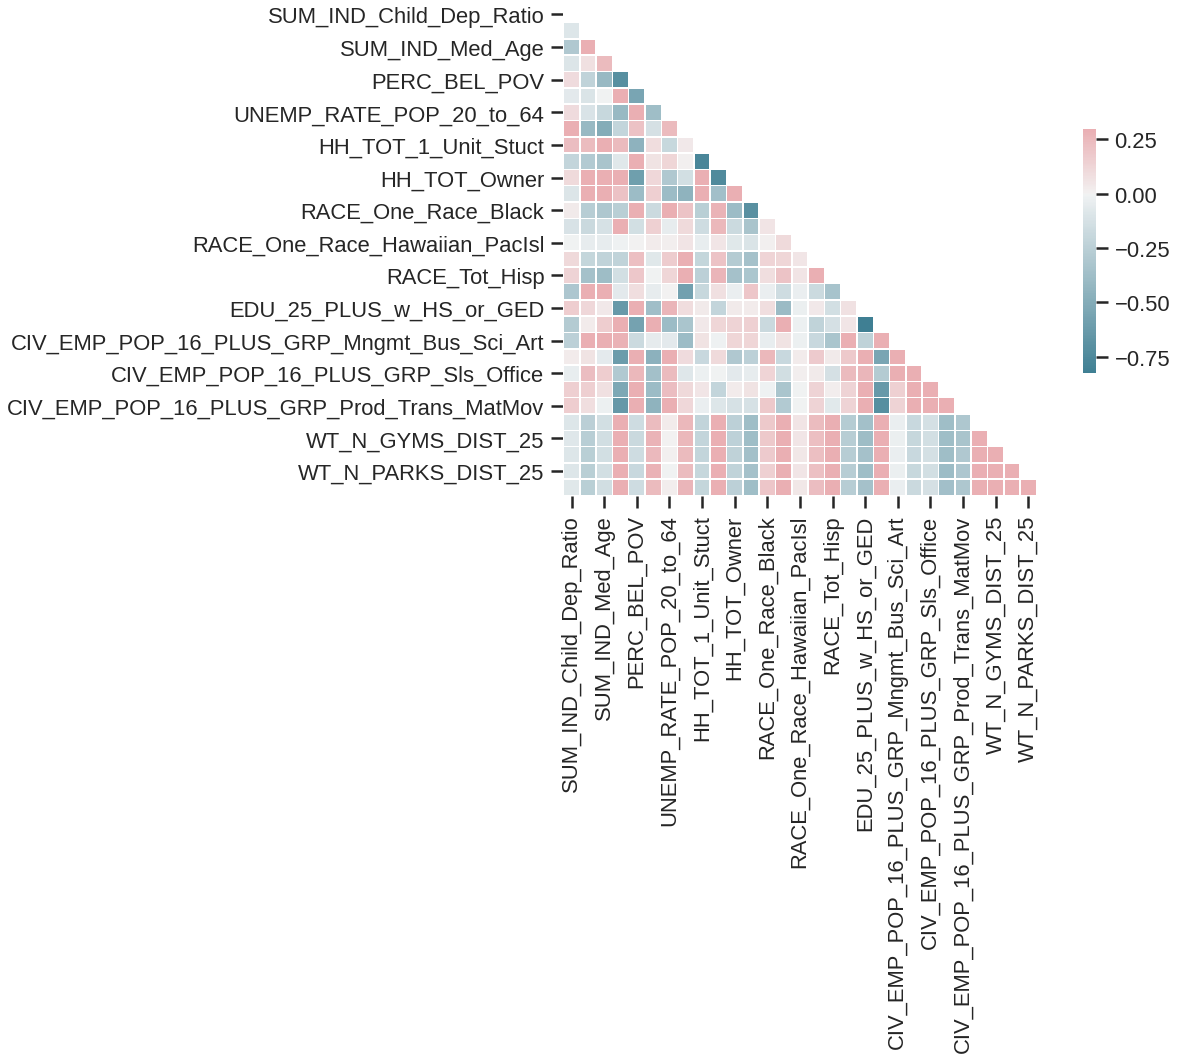

In [21]:
df_data = df_model[df_model.columns[~df_model.columns.isin(["GEOID","GEO_ID","NAME"])]]

plot_corr(df_data)

## Trisurface Plot for Correlation Matrix

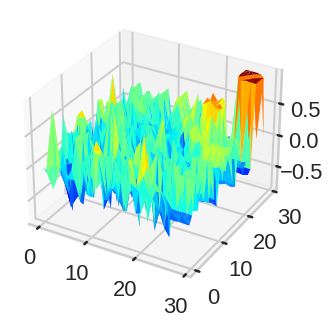

In [22]:
# generating correlation data 
df_corr = df_model[df_model.columns[~df_model.columns.isin(["GEOID","GEO_ID","NAME"])]].corr() 
df_corr.index = range(0, len(df_corr)) 
df_corr.rename(columns = dict(zip(df_corr.columns, df_corr.index)), inplace = True) 
df_corr = df_corr.astype(object) 
  
# Generating coordinates with corresponding correlation values 
for i in range(0, len(df_corr)): 
    for j in range(0, len(df_corr)): 
        if i != j: 
            df_corr.iloc[i, j] = (i, j, df_corr.iloc[i, j]) 
        else: 
            df_corr.iloc[i, j] = (i, j, 0) 

df_list = [] 
  
# flattening dataframe values 
for sub_list in df_corr.values: 
    df_list.extend(sub_list) 

# converting list of tuples into trivariate dataframe 
plot_df = pd.DataFrame(df_list) 
  
fig = plt.figure() 
ax = Axes3D(fig) 
  
# plotting 3D trisurface plot 
ax.plot_trisurf(plot_df[0], plot_df[1], plot_df[2], cmap = cm.jet, linewidth = 0.2) 
  
plt.show() 

# Dimensionality Reduction

## Principal Component Analysis (PCA)

### Inspect the Coordinates of the Right-Singular Vectors

In [23]:
# Print the shape
print("X:", X.shape)

# Find the minimum dimension
s = min(X.shape)
print("s = min({}, {}) == {}".format(X.shape[0], X.shape[1], s))

X: (73056, 30)
s = min(73056, 30) == 30


In [24]:
# Singular Value Decomposition
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)

print("U:", U.shape)
print("Sigma:", Sigma.shape)
print("VT:", VT.shape)

U: (73056, 30)
Sigma: (30,)
VT: (30, 30)


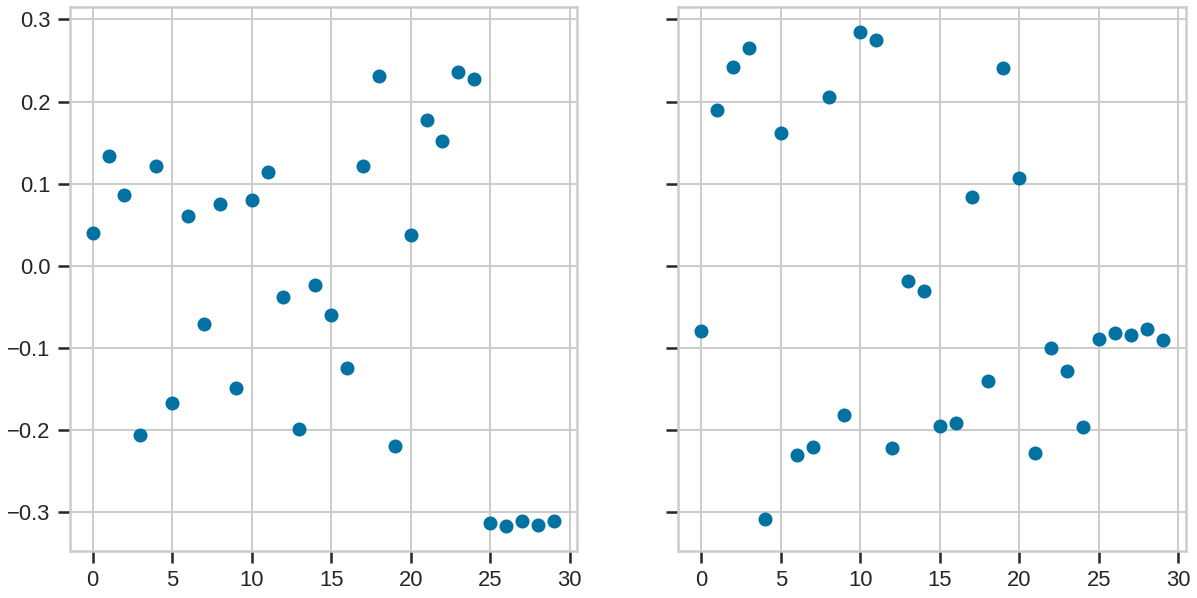

In [25]:
# Inspect the coordinates of the top two (k_approx, below) right-singular vectors
m, d = X.shape
k_approx = 2
assert k_approx <= s

# Plot the components of the first k_approx=2 singular vectors
fig, axs = plt.subplots(1, k_approx, sharex=True, sharey=True,
                        figsize=(10*k_approx, 10))
for k in range(k_approx):
    axs[k].scatter(np.arange(min(m, d)), VT[k, :].T)

These charts show column index on x axis. Left chart shows contribution of each column to the first principal component. The right chart whos the contribution of the second component. Most fields are non-zero, so nearly all have some contribution to explaining variance.

### 2D Scatter Plot

In [26]:
pca = PCA(n_components=2, svd_solver='full')
X_pca = pca.fit_transform(X)

print("Explained variation per principal component: {} \n".format(pca.explained_variance_ratio_))
print("Cumulative explained variation of the principal components: {}".format(np.sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.25680301 0.20756129] 

Cumulative explained variation of the principal components: 0.4643642979193596


(-9.128958016625042,
 10.952953176637067,
 -7.4672972460329445,
 12.614613947229163)

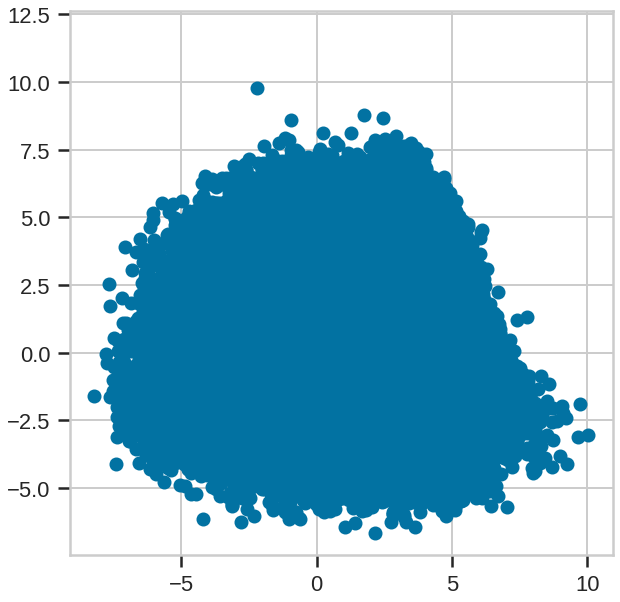

In [27]:
# It's possible to take the original data and project it onto the 2-dimensional subspace defined by the first two right-singular vectors.
df_pca = pd.DataFrame(data=X_pca, columns=["component_1", "component_2"])

fig = plt.figure(figsize=(10, 10))

plt.scatter(df_pca["component_1"], df_pca["component_2"])

ax = plt.gca()
ax.axis("square")

### 3D Scatter Plot

In [28]:
pca = PCA(n_components=3, svd_solver='full')
X_pca = pca.fit_transform(X)

print("Explained variation per principal component: {} \n".format(pca.explained_variance_ratio_))

print("Cumulative explained variation of the principal components: {}".format(np.sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.25680301 0.20756129 0.10227783] 

Cumulative explained variation of the principal components: 0.5666421327034153


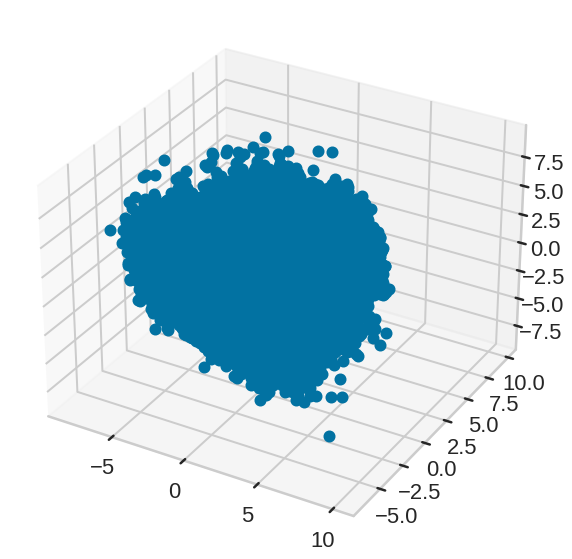

In [29]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')
plt.scatter(X_pca[:, 0], X_pca[:, 1], zs=X_pca[:, 2], depthshade=False, s=100)
plt.show()

## t-distributed Stochastic Neighbor Embedding (t-SNE)

In [30]:
# scikit-learn chooses the minimum number of principal components such that 95% of the variance is retained.
pca = PCA(.95, svd_solver="full") 

# Select the number of components for PCA
#pca = PCA(n_components=50, svd_solver='full')

# Transform the data
X_pca = pca.fit_transform(X)

# The number of total components
print("The total number of principal components: {} \n".format(len(pca.explained_variance_ratio_)))

print("Explained variation per principal component: {} \n".format(pca.explained_variance_ratio_))

# The explained variance tells you how much information (variance) can be attributed to each of the principal components.
print("Cumulative explained variation for the principal components: {}".format(np.sum(pca.explained_variance_ratio_)))

The total number of principal components: 18 

Explained variation per principal component: [0.25680301 0.20756129 0.10227783 0.07908216 0.0457931  0.04019259
 0.03406367 0.0318191  0.02583446 0.02459455 0.02119038 0.01894909
 0.01669356 0.01368523 0.01158092 0.00968708 0.00855905 0.00767776] 

Cumulative explained variation for the principal components: 0.9560448274769612


### 2D Scatter Plot

# TRY TO RUN, NOT NEEDED THOUGH

In [31]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, n_jobs=-1)
X_pca_tsne = tsne.fit_transform(X_pca)

print("Time elapsed: {} seconds".format(time.time()-time_start))

df_pca_tsne = pd.DataFrame(data=X_pca_tsne, columns=["component_1", "component_2"])

Time elapsed: 107.38633966445923 seconds


#### Version 1

<AxesSubplot:xlabel='component_1', ylabel='component_2'>

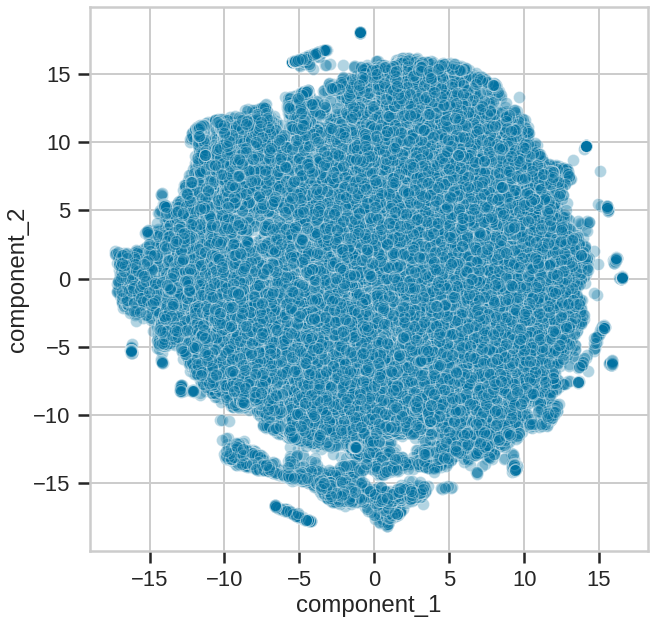

In [32]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="component_1", y="component_2",
    palette=sns.color_palette("hls", 10),
    data=df_pca_tsne,
    legend="full",
    alpha=0.3,
)

#### Version 2

(-19.004460334777832,
 20.89032669067383,
 -19.982886409759523,
 19.91190061569214)

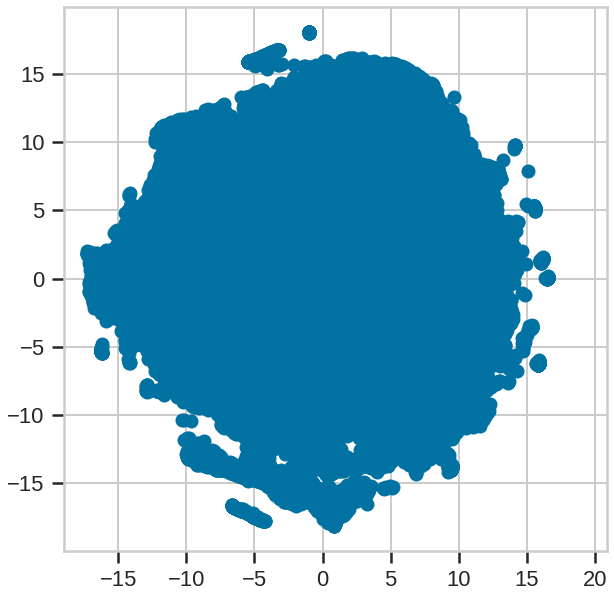

In [33]:
fig = plt.figure(figsize=(10, 10))

plt.scatter(df_pca_tsne["component_1"], df_pca_tsne["component_2"])

ax = plt.gca()
ax.axis("square")

# Clustering Models

In [34]:
# Save the results of the different clustering methods in a dictionary
cluster_results = {}

## Partitioning Methods

In [35]:
# Choose the appropriate Dimensionality Reduction technique and number of components 

# scikit-learn chooses the minimum number of principal components such that 95% of the variance is retained.
#pca = PCA(.95, svd_solver="full") 

# Select the number of components for PCA
pca = PCA(n_components=2, svd_solver='full')

# Transform the data
X_pca = pca.fit_transform(X)

# Select X_pca or X_pca_tsne
X_cluster = X_pca

In [36]:
# Choose the maximum number of clusters to test
max_clusters = 20

### KMeans

##### Characteristics

*Parameters:* number of clusters

*Scalability:* Very large n_smaples

*Usecase:* General-purpose, even cluster size, flat geometry, not too many clusters

*Geometry (metric used):* Distances between points

#### Choose the Appropriate Number of Clusters

In [37]:
time_start = time.time()

# Calculate the internal criteria that measure properties expected in a good clustering, compact and well-separated groups
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 1000,
    "random_state": 42,
}

# Create lists that hold the values of the different internal metrics for each k
sse = []
silhouette = []
calinski_harabasz = []
davies_bouldin = []

for k in range(2, max_clusters+1):
    model = KMeans(n_clusters=k, **kmeans_kwargs)
    model.fit(X_cluster)
    labels = model.fit_predict(X_cluster)
    
    sse.append(model.inertia_)
    
    score = silhouette_score(X_cluster, labels)
    silhouette.append(score)
    
    score = calinski_harabasz_score(X_cluster, labels)
    calinski_harabasz.append(score)
    
    score = davies_bouldin_score(X_cluster, labels)
    davies_bouldin.append(score)
    
print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 1986.1187233924866 seconds


##### Elbow Method - SSE

SSE: Quadratic error/Distorsion (k-means); the lower number the better

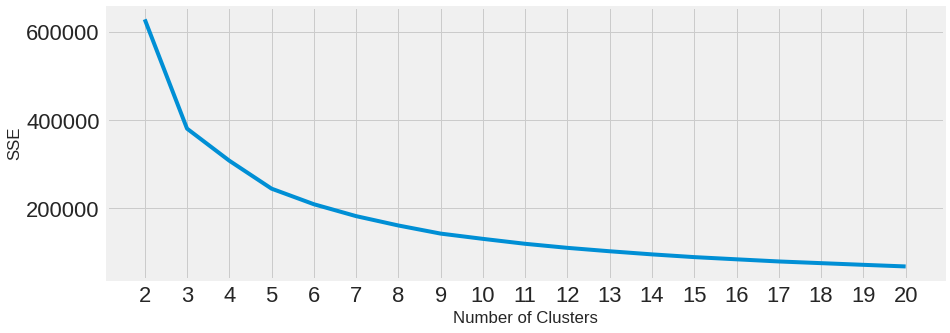

In [38]:
plot_internal_validity(max_clusters, sse, "SSE")

In [39]:
kl = KneeLocator(
    range(2, max_clusters+1), sse, curve="convex", direction="decreasing"
)

n_clusters = kl.elbow
n_clusters

6

##### Internal Validity Measures

Silhouette Coefficient: maximum class spread/variance; the higher number the better

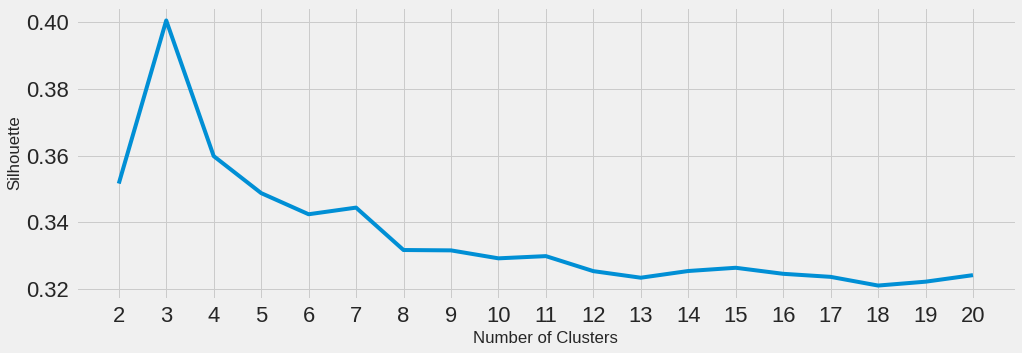

In [40]:
plot_internal_validity(max_clusters, silhouette, "Silhouette")

Calinski-Harabasz Index: interclass-intraclass distance ratio; the higher the number the better

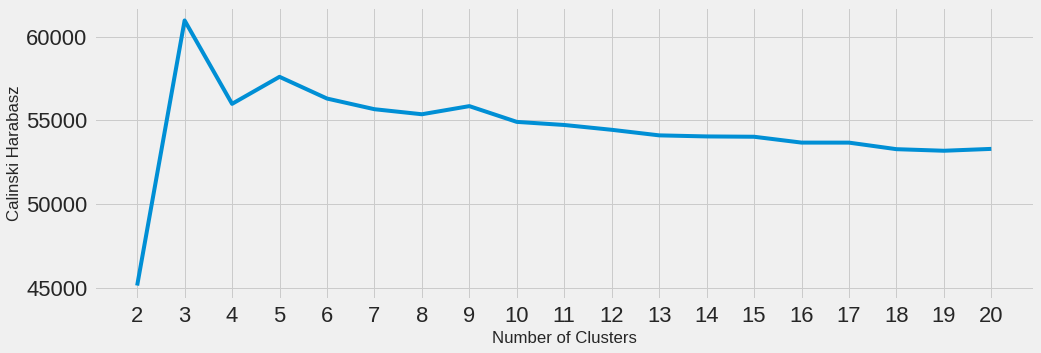

In [41]:
plot_internal_validity(max_clusters, calinski_harabasz, "Calinski Harabasz")

Davies-Bouldin Criteria: maximum interclass-intraclass distance ratio; the lower the number the better

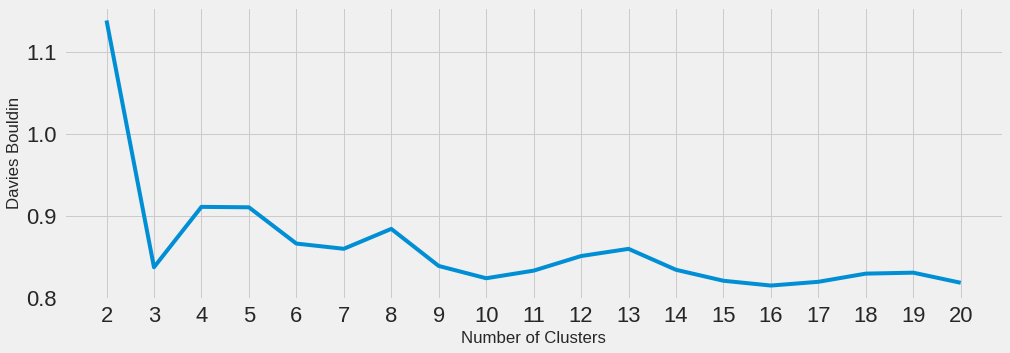

In [42]:
plot_internal_validity(max_clusters, davies_bouldin, "Davies Bouldin")

##### The Gap Statistic

In [43]:
# Create an "optimalK" object
optimalK = OptimalK(parallel_backend='rust')
optimalK

OptimalK(n_jobs=14, parallel_backend="rust")

In [44]:
# Call "optimalK" with a list of clusters to fit to
n_clusters = optimalK(X_cluster, cluster_array=np.arange(1, max_clusters+1))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  20


In [45]:
# A DataFrame of gap values with each passed cluster count is now available
#optimalK.gap_df.head()

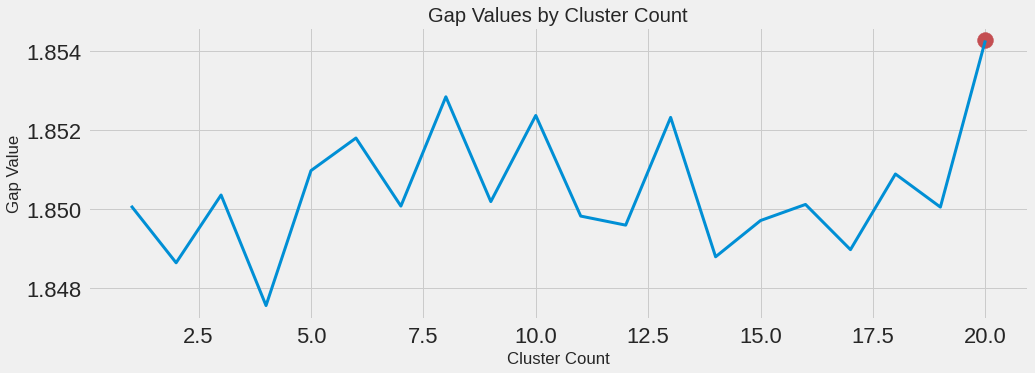

In [46]:
# Plot the n_clusters against their gap values
fig = plt.figure(figsize=(15,5))
plt.style.use("fivethirtyeight")
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

#### Model with Optimal Number of Clusters

In [47]:
# Select the optimal number of clusters
optimal_clusters = 10

In [48]:
time_start = time.time()

# Instantiate the k-means algorithm
kmeans_kwargs = {
    "init": "k-means++",
    "n_clusters": optimal_clusters,
    "n_init": 50,
    "max_iter": 1000,
    "algorithm": "full",
    "random_state": 42,
}

kmeans = KMeans(**kmeans_kwargs)

# Fit the algorithm to the features
kmeans.fit(X_cluster)

# Save the model results
cluster_results["kmeans"] = kmeans

print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 14.558552503585815 seconds


In [49]:
# The number of iterations required to converge
kmeans.n_iter_

15

In [50]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[ 1.26349434, -2.28885555],
       [-1.30609996,  0.08175851],
       [ 2.89504358,  4.00547621],
       [-0.65529542,  3.85922886],
       [-4.06267523, -1.265391  ],
       [ 3.79510709,  0.12310678],
       [-1.43315689, -2.39172652],
       [ 4.10940468, -3.15308099],
       [ 1.05609942,  1.03785575],
       [-3.46764764,  1.91495783]])

In [51]:
# Retrieve the labels
labels = kmeans.labels_

In [52]:
# The lowest SSE value
print("SSE (Inertia): {}".format(round(kmeans.inertia_, 4)))

SSE (Inertia): 131057.3556


In [53]:
# Compute the "silhouette score" for the algorithm
print("Silhouette Score: {}".format(silhouette_score(X_cluster, labels).round(4)))

Silhouette Score: 0.3292


In [54]:
# Compute the "calinski harabasz score" for the algorithm
print("Calinski Harabasz Score: {}".format(calinski_harabasz_score(X_cluster, labels).round(4)))

Calinski Harabasz Score: 54913.1014


In [55]:
# Compute the "davies bouldin score" for the algorithm
print("Davies Bouldin Score: {}".format(davies_bouldin_score(X_cluster, labels).round(4)))

Davies Bouldin Score: 0.8278


#### Visualization of Clusters

##### 2D

In [56]:
# The dataset utilized for clustering may have used more than 2 components
# So, take the original processed matrix "X" and project it onto 2 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(2, X, labels)
#df_tsne = prepare_tsne(2, X, labels)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

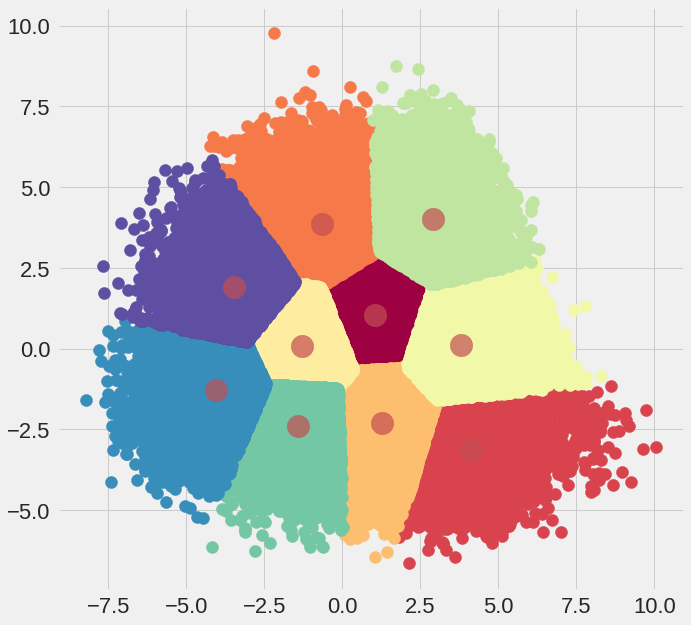

In [57]:
plot_2d(df_pca, kmeans, centers=True)

##### 3D

In [58]:
# The dataset utilized for clustering may have more than 3 components
# So, take the original processed matrix "X" and project it onto 3 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(3, X, labels)
#df_tsne = prepare_tsne(3, X, labels)

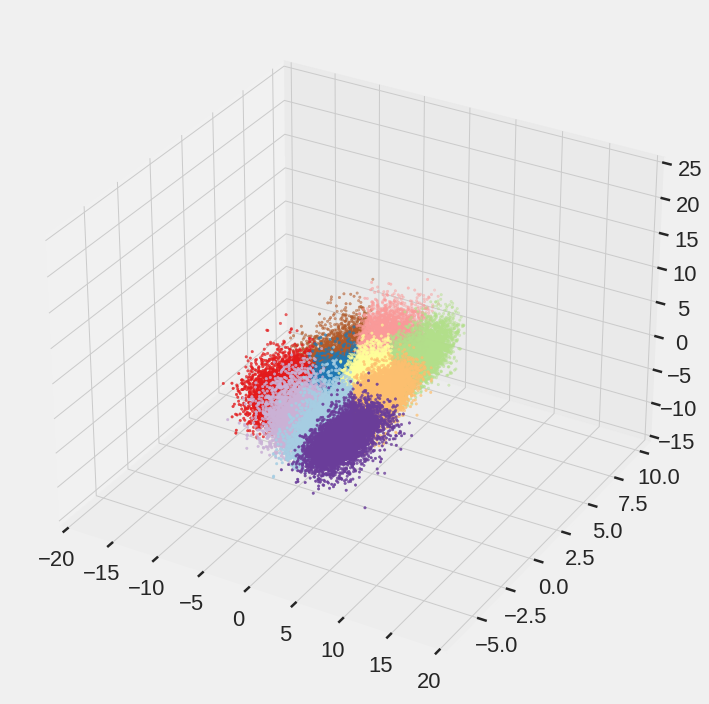

In [59]:
plot_3d(df_pca)

### Mini-Batch KMeans

Mini-Batch K-Means is a modified version of k-means that makes updates to the cluster centroids using mini-batches of samples rather than the entire dataset, which can make it faster for large datasets, and perhaps more robust to statistical noise.

#### Choose the Appropriate Number of Clusters

In [60]:
# Create lists that hold the values of the different internal metrics for each k

time_start = time.time()

silhouette = []
calinski_harabasz = []
davies_bouldin = []

for k in range(2, max_clusters+1):
    model = MiniBatchKMeans(n_clusters=k)
    model.fit(X_cluster)
    labels = model.fit_predict(X_cluster)
    
    score = silhouette_score(X_cluster, labels)
    silhouette.append(score)
    
    score = calinski_harabasz_score(X_cluster, labels)
    calinski_harabasz.append(score)
    
    score = davies_bouldin_score(X_cluster, labels)
    davies_bouldin.append(score)
    
print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 1915.99467420578 seconds


##### Internal Validity Measures

Silhouette Coefficient: maximum class spread/variance; the higher number the better

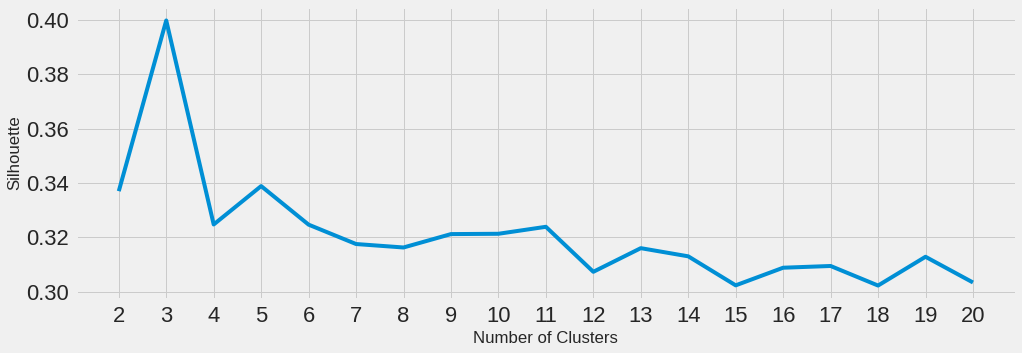

In [61]:
plot_internal_validity(max_clusters, silhouette, "Silhouette")

Calinski-Harabasz Index: interclass-intraclass distance ratio; the higher the number the better

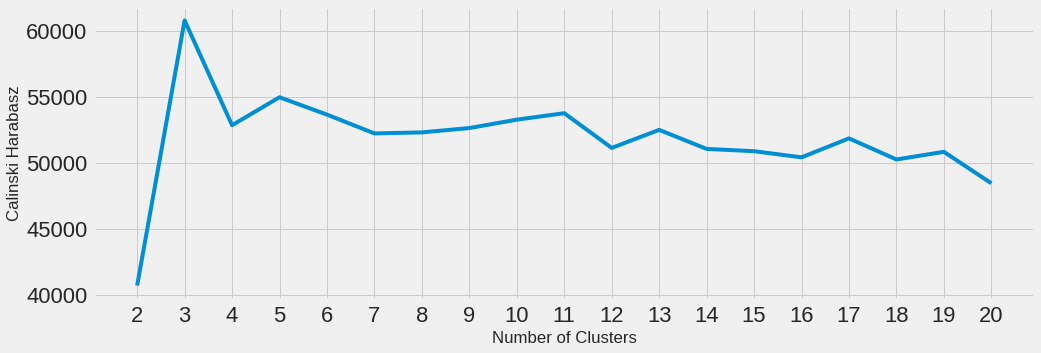

In [62]:
plot_internal_validity(max_clusters, calinski_harabasz, "Calinski Harabasz")

Davies-Bouldin Criteria: maximum interclass-intraclass distance ratio; the lower the number the better

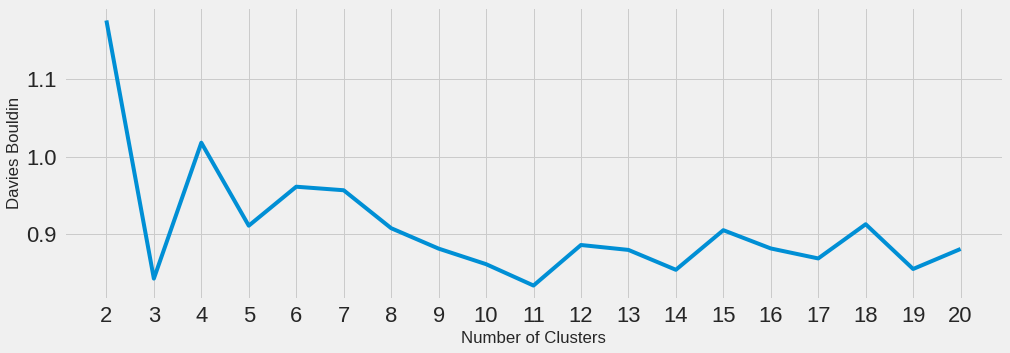

In [63]:
plot_internal_validity(max_clusters, davies_bouldin, "Davies Bouldin")

##### The Gap Statistic

In [64]:
# The "Gap Statistic" module allows using any clustering algorithm
# This function takes X (data) k, and func (the chosen clustering algorithm)
# It returns a tuple of the centorid locations, and the labels assigned to X

def special_clustering_func(X, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    m = MiniBatchKMeans()
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)

In [65]:
# Create an "optimalK" object
optimalK = OptimalK(clusterer=special_clustering_func)
optimalK

OptimalK(n_jobs=14, parallel_backend="joblib")

In [66]:
# Call "optimalK" with a list of clusters to fit to
n_clusters = optimalK(X_cluster, n_refs=3, cluster_array=np.arange(1, 20))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  12


In [67]:
# A DataFrame of gap values with each passed cluster count is now available
#optimalK.gap_df.head()

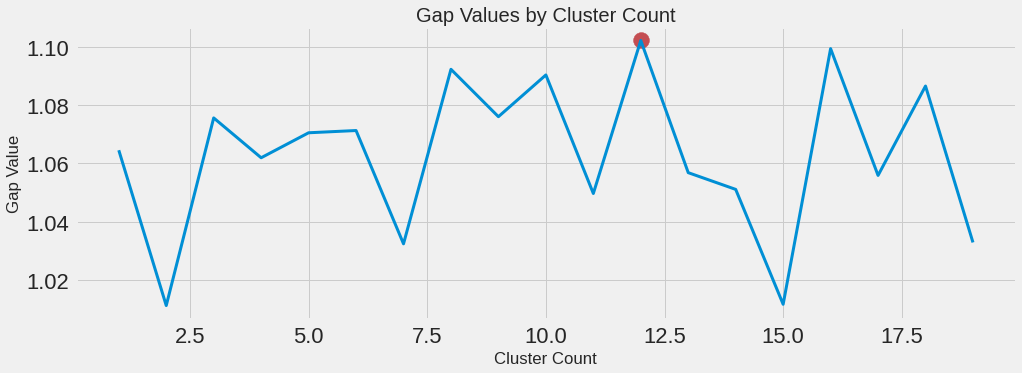

In [68]:
# Plot the n_clusters against their gap values
fig = plt.figure(figsize=(15,5))
plt.style.use("fivethirtyeight")
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

#### Model with Optimal Number of Clusters

In [69]:
# Select the optimal number of clusters
optimal_clusters = 19

In [70]:
time_start = time.time()

minibatch_kmeans = MiniBatchKMeans(n_clusters=optimal_clusters)

# Fit the algorithm to the features
minibatch_kmeans.fit(X_cluster)

# Save the model results
cluster_results["minibatch_kmeans"] = minibatch_kmeans

print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 0.30846238136291504 seconds


In [71]:
# The number of iterations required to converge
minibatch_kmeans.n_iter_

11

In [72]:
# Final locations of the centroid
minibatch_kmeans.cluster_centers_

array([[ 0.90225429, -2.54435562],
       [-2.8208956 ,  2.33889107],
       [ 2.31178911,  2.1116426 ],
       [-0.55460779,  1.41533623],
       [-4.47904888, -1.97046265],
       [ 4.92720912, -3.14075107],
       [-2.13191293, -0.6207464 ],
       [ 2.97097998, -1.90940692],
       [ 0.21292437,  3.5308149 ],
       [ 2.50407143,  4.9940424 ],
       [ 0.72419221, -0.37909583],
       [ 2.11087164, -3.94596031],
       [-3.96875713,  0.25649773],
       [ 2.89516301,  0.34248208],
       [-1.37903653,  4.99555511],
       [-2.20443254, -2.65329262],
       [ 4.13564415,  3.67327697],
       [-0.64261249, -1.9700522 ],
       [ 5.13845378, -0.4335959 ]])

In [73]:
# Retrieve the labels
labels = minibatch_kmeans.labels_

In [74]:
# The lowest SSE value
print("SSE (Inertia): {}".format(minibatch_kmeans.inertia_.round(4)))

SSE (Inertia): 77841.9465


In [75]:
# Compute the "silhouette score" for the algorithm
print("Silhouette Score: {}".format(silhouette_score(X_cluster, labels).round(4)))

Silhouette Score: 0.3014


In [76]:
# Compute the "calinski harabasz score" for the algorithm
print("Calinski Harabasz Score: {}".format(calinski_harabasz_score(X_cluster, labels).round(4)))

Calinski Harabasz Score: 49664.9969


In [77]:
# Compute the "davies bouldin score" for the algorithm
print("Davies Bouldin Score: {}".format(davies_bouldin_score(X_cluster, labels).round(4)))

Davies Bouldin Score: 0.885


#### Visualization of Clusters

##### 2D

In [78]:
# The dataset utilized for clustering may have used more than 2 components
# So, take the original processed matrix "X" and project it onto 2 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(2, X, labels)
#df_tsne = prepare_tsne(2, X, labels)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

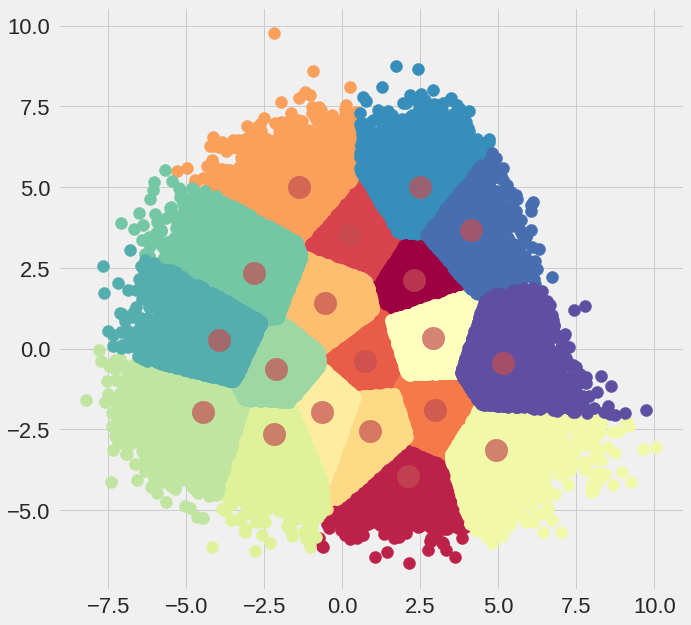

In [79]:
plot_2d(df_pca, minibatch_kmeans, centers=True)

##### 3D

In [80]:
# The dataset utilized for clustering may have more than 3 components
# So, take the original processed matrix "X" and project it onto 3 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(3, X, labels)
#df_tsne = prepare_tsne(3, X, labels)

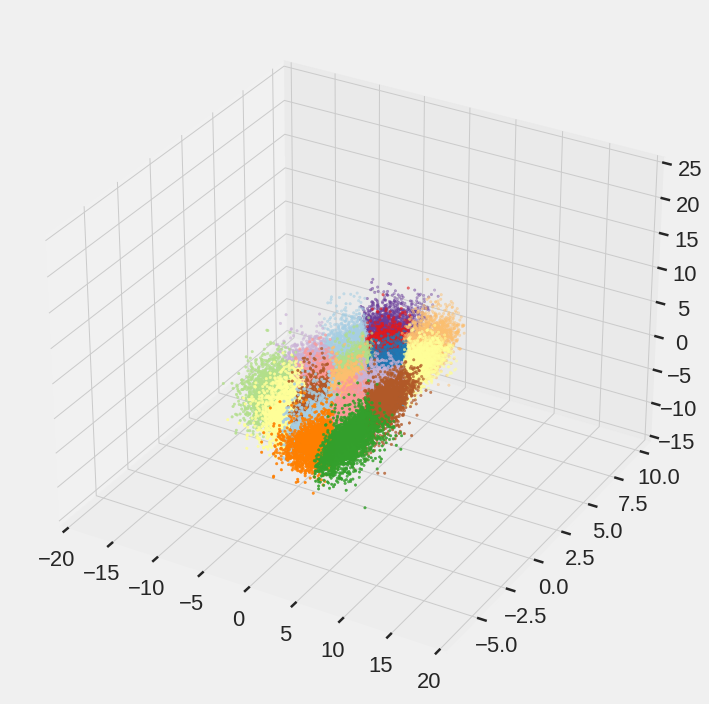

In [81]:
plot_3d(df_pca)

### Spectral Clustering

##### Characteristics

*Parameters:* number of clusters

*Scalability:* Medium n_samples, small n_clusters

*Usecase:* Few clusters, even clsuter size, non-flat geometry

*Geometry (metric used):* Graph distance (e.g., nearest-neighbor graph)

#### Choose the Appropriate Number of Clusters

In [82]:
time_start = time.time()

# Create lists that hold the values of the different internal metrics for each k
silhouette = []
calinski_harabasz = []
davies_bouldin = []

for k in range(2, max_clusters+1):
    model = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=15)
    model.fit(X_cluster)
    labels = model.fit_predict(X_cluster)
    
    score = silhouette_score(X_cluster, labels)
    silhouette.append(score)
    
    score = calinski_harabasz_score(X_cluster, labels)
    calinski_harabasz.append(score)
    
    score = davies_bouldin_score(X_cluster, labels)
    davies_bouldin.append(score)
    
print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 7906.5948169231415 seconds


##### Internal Validity Measures

Silhouette Coefficient: maximum class spread/variance; the higher number the better

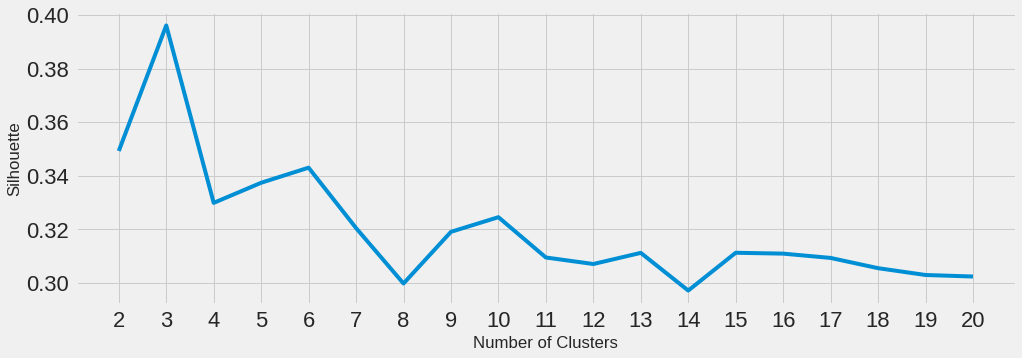

In [83]:
plot_internal_validity(max_clusters, silhouette, "Silhouette")

Calinski-Harabasz Index: interclass-intraclass distance ratio; the higher the number the better

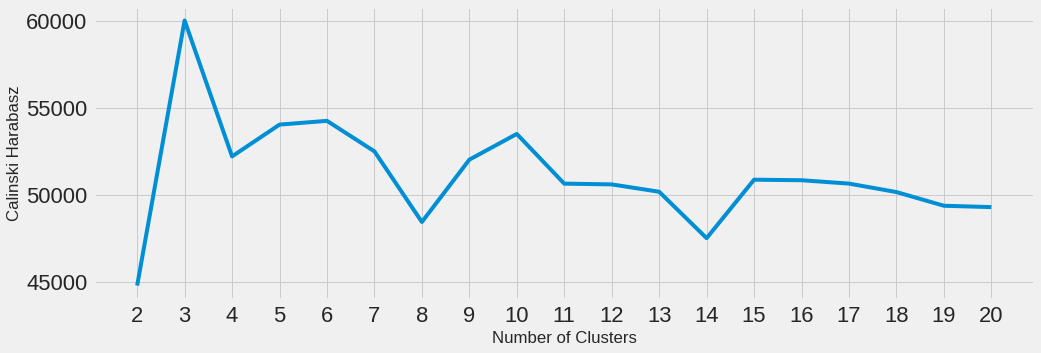

In [84]:
plot_internal_validity(max_clusters, calinski_harabasz, "Calinski Harabasz")

Davies-Bouldin Criteria: maximum interclass-intraclass distance ratio; the lower the number the better

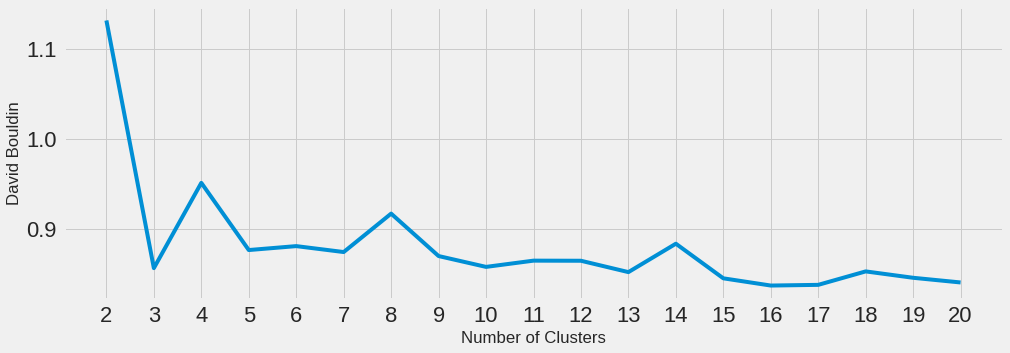

In [85]:
plot_internal_validity(max_clusters, davies_bouldin, "David Bouldin")

#### Model with Optimal Number of Clusters

In [86]:
# Select the optimal number of clusters
optimal_clusters = 3

In [87]:
time_start = time.time()

spectral_clustering = SpectralClustering(n_clusters=optimal_clusters, affinity='nearest_neighbors', n_neighbors=15)

# Fit the algorithm to the features
spectral_clustering.fit(X_cluster)

# Save the model results
cluster_results["spectral_clustering"] = spectral_clustering

print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 200.75126433372498 seconds


In [88]:
# Retrieve the labels
labels = spectral_clustering.labels_

In [89]:
# Compute the "silhouette score" for the algorithm
print("Silhouette Score: {}".format(silhouette_score(X_cluster, labels).round(4)))

Silhouette Score: 0.3961


In [90]:
# Compute the "calinski harabasz score" for the algorithm
print("Calinski Harabasz Score: {}".format(calinski_harabasz_score(X_cluster, labels).round(4)))

Calinski Harabasz Score: 60044.4242


In [91]:
# Compute the "davies bouldin score" for the algorithm
print("Davies Bouldin Score: {}".format(davies_bouldin_score(X_cluster, labels).round(4)))

Davies Bouldin Score: 0.8563


#### Visualization of Clusters

##### 2D

In [92]:
# The dataset utilized for clustering may have used more than 2 components
# So, take the original processed matrix "X" and project it onto 2 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(2, X, labels)
#df_tsne = prepare_tsne(2, X, labels)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


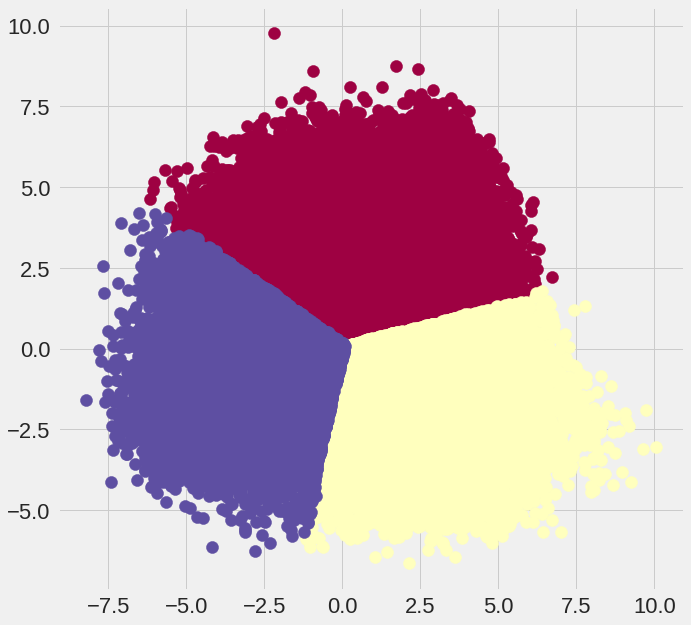

In [93]:
plot_2d(df_pca, spectral_clustering, centers=False)

##### 3D

In [94]:
# The dataset utilized for clustering may have more than 3 components
# So, take the original processed matrix "X" and project it onto 3 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(3, X, labels)
#df_tsne = prepare_tsne(3, X, labels)

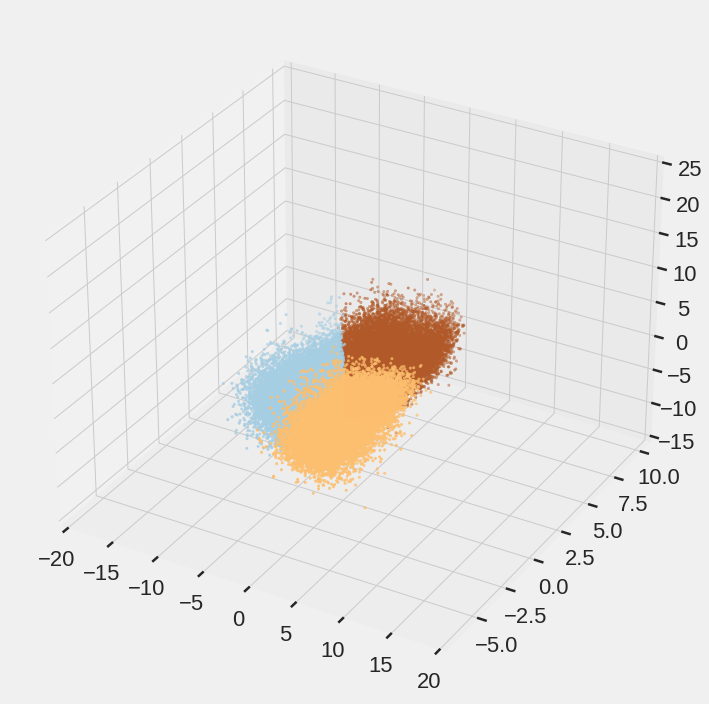

In [95]:
plot_3d(df_pca)

## Hierarchical Method

# UPDATE

In [96]:
# Choose the appropriate Dimensionality Reduction technique and number of components 

# scikit-learn chooses the minimum number of principal components such that 95% of the variance is retained.
pca = PCA(.95, svd_solver="full") 

# Select the number of components for PCA
#pca = PCA(n_components=2, svd_solver='full')

# Transform the data
X_pca = pca.fit_transform(X)

# Select X_pca or X_pca_tsne
X_cluster = X_pca

In [97]:
# Choose the maximum number of clusters to test
max_clusters = 10

### Ward Linkage (Agglomerative Clustering)

##### Characteristics

*Parameters:* number of clusters or distance threshold

*Scalability:* Large n_samples and n_clusters

*Usecase:* Many clusters, possibly connectivity constraints

*Geometry (metric used):* distances between points

#### Choose the Appropriate Number of Clusters

In [98]:
time_start = time.time()

# Create lists that hold the values of the different internal metrics for each k
silhouette = []
calinski_harabasz = []
davies_bouldin = []

for k in range(2, max_clusters+1):
    model = AgglomerativeClustering(linkage="ward", n_clusters=k)
    model.fit(X_cluster)
    labels = model.fit_predict(X_cluster)
    
    score = silhouette_score(X_cluster, labels)
    silhouette.append(score)
    
    score = calinski_harabasz_score(X_cluster, labels)
    calinski_harabasz.append(score)
    
    score = davies_bouldin_score(X_cluster, labels)
    davies_bouldin.append(score)
    
print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 13859.600641727448 seconds


##### Internal Validity Measures

Silhouette Coefficient: maximum class spread/variance; the higher number the better

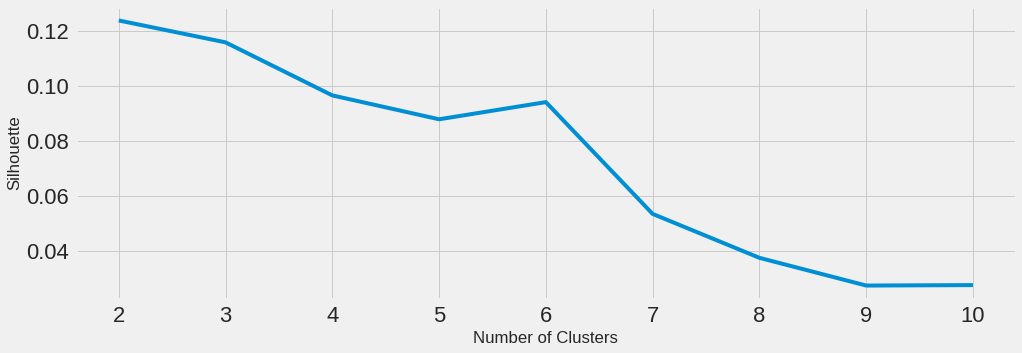

In [99]:
plot_internal_validity(max_clusters, silhouette, "Silhouette")

Calinski-Harabasz Index: interclass-intraclass distance ratio; the higher the number the better

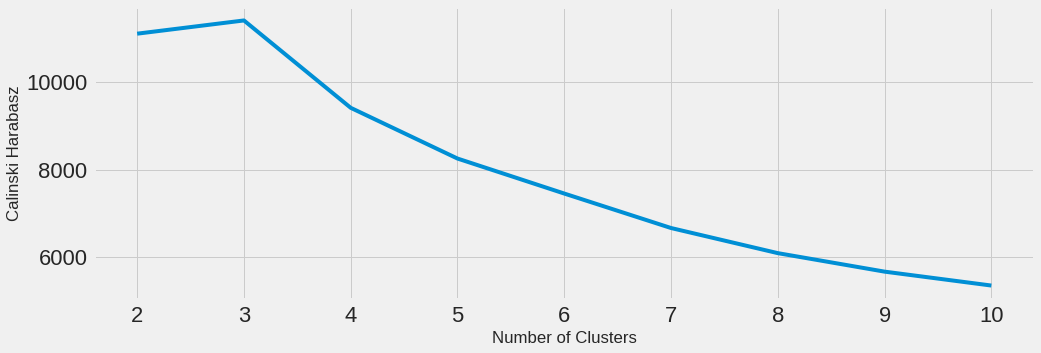

In [100]:
plot_internal_validity(max_clusters, calinski_harabasz, "Calinski Harabasz")

Davies-Bouldin Criteria: maximum interclass-intraclass distance ratio; the lower the number the better

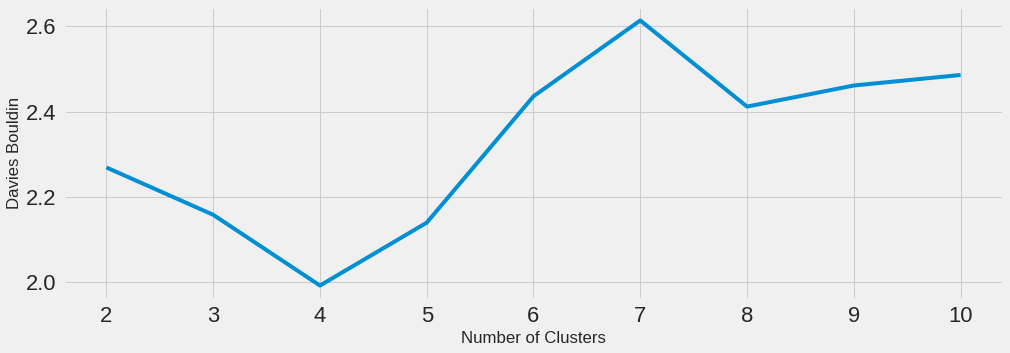

In [101]:
plot_internal_validity(max_clusters, davies_bouldin, "Davies Bouldin")

#### Model with Optimal Number of Clusters

In [102]:
# Select the optimal number of clusters
optimal_clusters = 3

In [103]:
time_start = time.time()

hierarchical_ward = AgglomerativeClustering(linkage="ward", n_clusters=optimal_clusters)

# Fit the algorithm to the features
hierarchical_ward.fit(X_cluster)

# Save the model results
cluster_results["hierarchical_ward"] = hierarchical_ward

print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 694.670307636261 seconds


In [104]:
# Retrieve the labels
labels = hierarchical_ward.labels_

In [105]:
# Compute the "silhouette score" for the algorithm
print("Silhouette Score: {}".format(silhouette_score(X_cluster, labels).round(4)))

Silhouette Score: 0.1237


In [106]:
# Compute the "calinski harabasz score" for the algorithm
print("Calinski Harabasz Score: {}".format(calinski_harabasz_score(X_cluster, labels).round(4)))

Calinski Harabasz Score: 11107.5878


In [107]:
# Compute the "davies bouldin score" for the algorithm
print("Davies Bouldin Score: {}".format(davies_bouldin_score(X_cluster, labels).round(4)))

Davies Bouldin Score: 2.2689


#### Visualization of Clusters

##### 2D

In [108]:
# The dataset utilized for clustering may have used more than 2 components
# So, take the original processed matrix "X" and project it onto 2 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(2, X, labels)
#df_tsne = prepare_tsne(2, X, labels)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


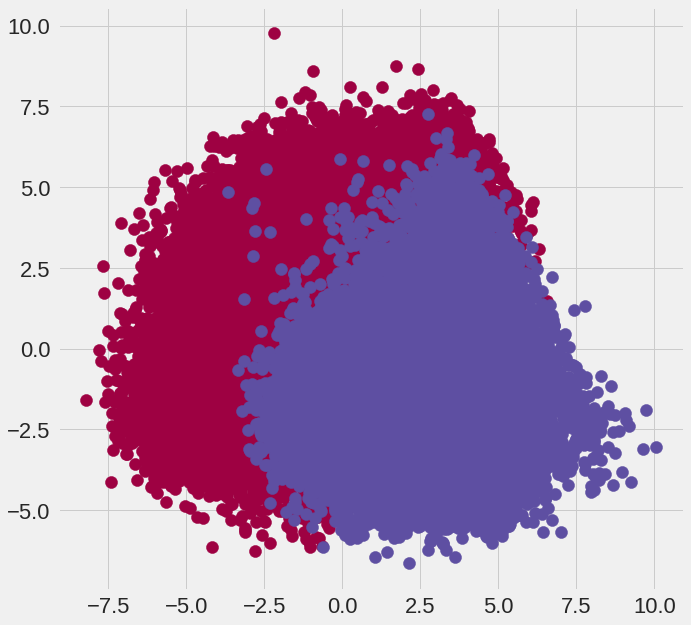

In [109]:
plot_2d(df_pca, hierarchical_ward, centers=False)

##### 3D

In [110]:
# The dataset utilized for clustering may have more than 3 components
# So, take the original processed matrix "X" and project it onto 3 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(3, X, labels)
#df_tsne = prepare_tsne(3, X, labels)

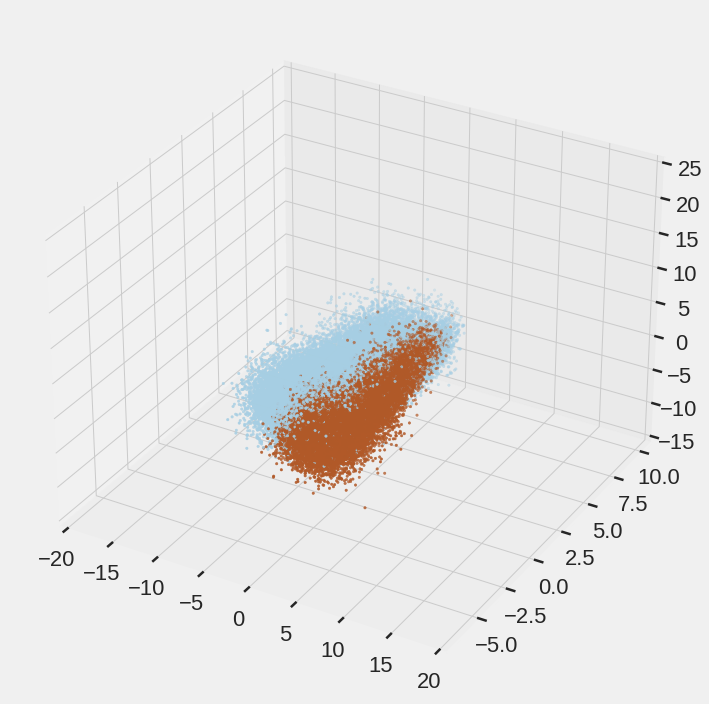

In [111]:
plot_3d(df_pca)

## Hierarchical Method

In [112]:
# Choose the appropriate Dimensionality Reduction technique and number of components 

# scikit-learn chooses the minimum number of principal components such that 95% of the variance is retained.
#pca = PCA(.95, svd_solver="full") 

# Select the number of components for PCA
pca = PCA(n_components=2, svd_solver='full')

# Transform the data
X_pca = pca.fit_transform(X)

# Select X_pca or X_pca_tsne
X_cluster = X_pca

In [113]:
# Choose the maximum number of clusters to test
max_clusters = 10

### BIRCH

##### Characteristics

*Parameters:* branching factor, treshold, optional global clusterer

*Scalability:* Large n_clusters and n_samples. BIRCH does not scale very well to high dimensional data. As a rule of thumb if n_features is greater than twenty, it is generally better to use MiniBatchKMeans.

*Usecase:* Large dataset, outlier removal, data reduction

*Geometry (metric used):* Euclidean distance between points

#### Choose the Appropriate Number of Clusters

In [114]:
time_start = time.time()

# Create lists that hold the values of the different internal metrics for each k
silhouette = []
calinski_harabasz = []
davies_bouldin = []

for k in range(2, max_clusters+1):
    model = Birch(threshold=0.01, n_clusters=k)
    model.fit(X_cluster)
    labels = model.fit_predict(X_cluster)
    
    score = silhouette_score(X_cluster, labels)
    silhouette.append(score)
    
    score = calinski_harabasz_score(X_cluster, labels)
    calinski_harabasz.append(score)
    
    score = davies_bouldin_score(X_cluster, labels)
    davies_bouldin.append(score)
    
print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 4187.014847517014 seconds


##### Internal Validity Measures

Silhouette Coefficient: maximum class spread/variance; the higher number the better

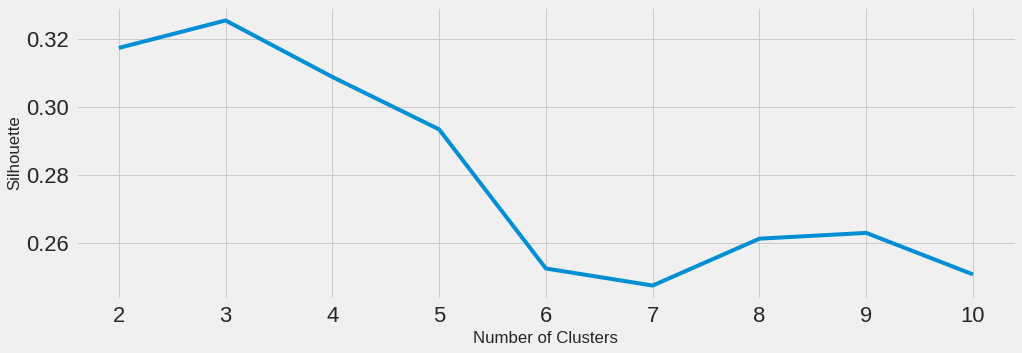

In [115]:
plot_internal_validity(max_clusters, silhouette, "Silhouette")

Calinski-Harabasz Index: interclass-intraclass distance ratio; the higher the number the better

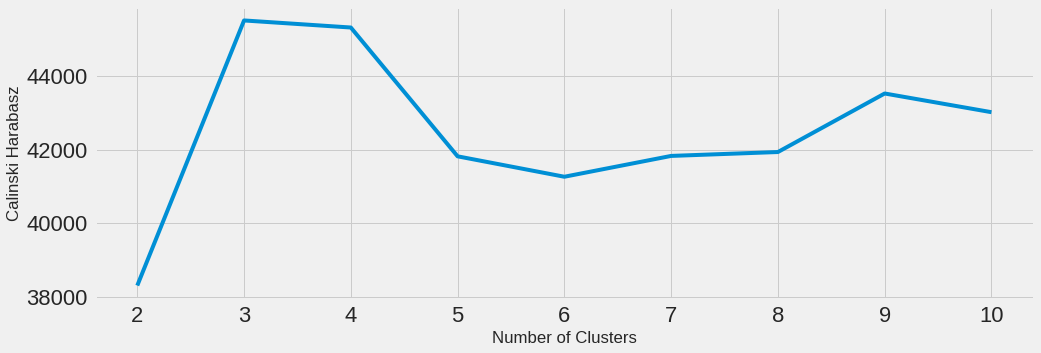

In [116]:
plot_internal_validity(max_clusters, calinski_harabasz, "Calinski Harabasz")

Davies-Bouldin Criteria: maximum interclass-intraclass distance ratio; the lower the number the better

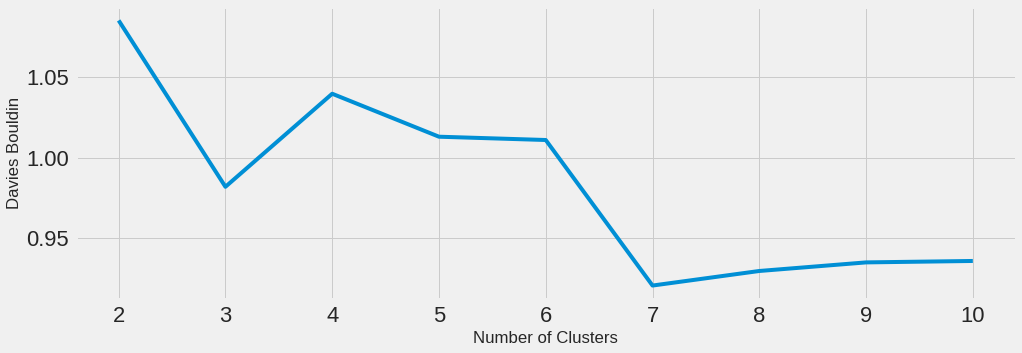

In [117]:
plot_internal_validity(max_clusters, davies_bouldin, "Davies Bouldin")

#### Model with Optimal Number of Clusters

In [118]:
# Select the optimal number of clusters
optimal_clusters = 3

In [119]:
time_start = time.time()

hierarchical_birch = Birch(threshold=0.01, n_clusters=optimal_clusters)

# Fit the algorithm to the features
hierarchical_birch.fit(X_cluster)

# Save the model results
cluster_results["hierarchical_birch"] = hierarchical_birch

print("Time elapsed: {} seconds".format(time.time()-time_start))

Time elapsed: 179.87563943862915 seconds


In [120]:
# Retrieve the labels
labels = hierarchical_birch.labels_

In [121]:
# Compute the "silhouette score" for the algorithm
print("Silhouette Score: {}".format(silhouette_score(X_cluster, labels).round(4)))

Silhouette Score: 0.3175


In [122]:
# Compute the "calinski harabasz score" for the algorithm
print("Calinski Harabasz Score: {}".format(calinski_harabasz_score(X_cluster, labels).round(4)))

Calinski Harabasz Score: 38314.064


In [123]:
# Compute the "davies bouldin score" for the algorithm
print("Davies Bouldin Score: {}".format(davies_bouldin_score(X_cluster, labels).round(4)))

Davies Bouldin Score: 1.0854


#### Visualization of Clusters

##### 2D

In [124]:
# The dataset utilized for clustering may have used more than 2 components
# So, take the original processed matrix "X" and project it onto 2 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(2, X, labels)
#df_tsne = prepare_tsne(2, X, labels)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


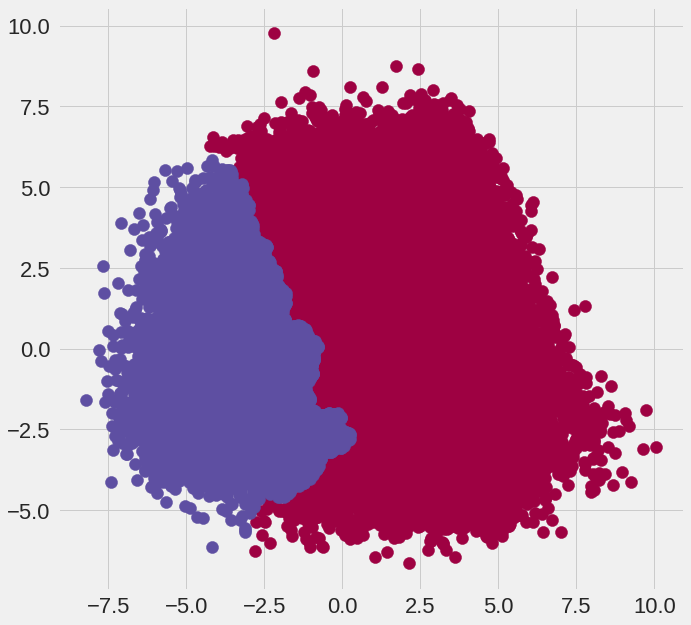

In [125]:
plot_2d(df_pca, hierarchical_birch, centers=False)

##### 3D

In [126]:
# The dataset utilized for clustering may have more than 3 components
# So, take the original processed matrix "X" and project it onto 3 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(3, X, labels)
#df_tsne = prepare_tsne(3, X, labels)

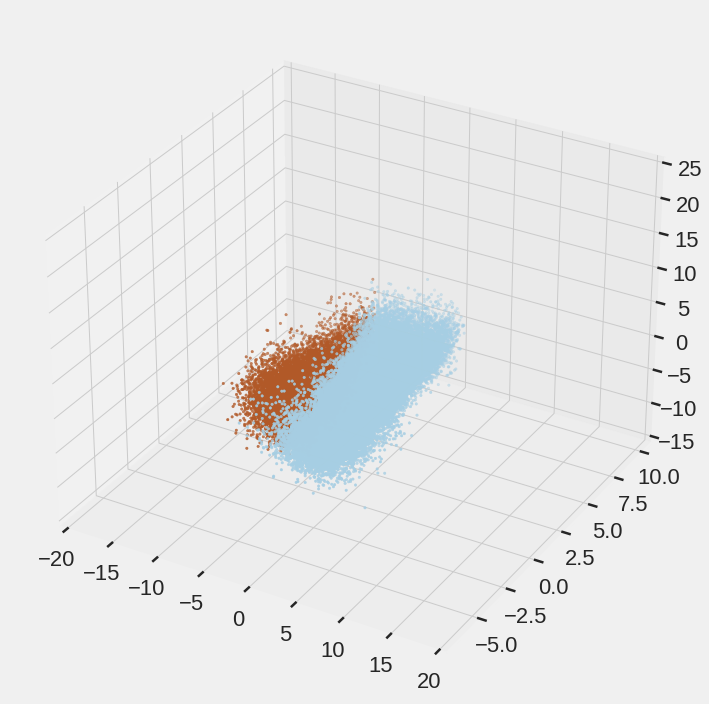

In [127]:
plot_3d(df_pca)

## Consensus Clustering

In [128]:
# Choose the appropriate Dimensionality Reduction technique and number of components 

# scikit-learn chooses the minimum number of principal components such that 95% of the variance is retained.
#pca = PCA(.95, svd_solver="full") 

# Select the number of components for PCA
pca = PCA(n_components=2, svd_solver='full')

# Transform the data
X_pca = pca.fit_transform(X)

# Select X_pca or X_pca_tsne
X_cluster = X_pca

In [129]:
# Choose the maximum number of clusters to test
max_clusters = 20

### Simple Consensus Clustering

n_clusters = Number of clusters

n_clusters_base = Number of clusters to use the base classifier

n_components = Number of components of the consensus

ncb_rand = If the number of clusters of each component is chosen randomly in the interval [ 2..n_clusters ]

In [1]:
k = 2
km = KMeans(n_clusters=k)

cons = SimpleConsensusClustering(n_clusters=k, n_clusters_base=4, n_components=10, ncb_rand=False)

lkm = km.fit_predict(X_cluster)
cons.fit(X_cluster)
lcons = cons.labels_

print('K-M SS =', silhouette_score(X_cluster, labels))
print('SCC SS =', silhouette_score(X_cluster, labels))

NameError: name 'KMeans' is not defined

# Evaluate the Constructed Models

In [ ]:
# Pickle the "cluster_results" dictionary
with open("cluster_results.obj", 'wb') as fp:
    pickle.dump(cluster_results, fp)

## Internal Validity Measures

In [ ]:
# Choose the appropriate Dimensionality Reduction technique and number of components 

# scikit-learn chooses the minimum number of principal components such that 95% of the variance is retained.
#pca = PCA(.95, svd_solver="full") 

# Select the number of components for PCA
pca = PCA(n_components=2, svd_solver='full')

# Transform the data
X_pca = pca.fit_transform(X)

# Select X_pca or X_pca_tsne
X_cluster = X_pca

### Obtain the Results

In [ ]:
model_names = []
silhouette = []
calinski_harabasz = []
davies_bouldin = []

for key in cluster_results.keys():
    model_names.append(key)
    model = cluster_results[key]
    labels = model.labels_
    
    score = silhouette_score(X_cluster, labels)
    silhouette.append(score)
    
    score = calinski_harabasz_score(X_cluster, labels)
    calinski_harabasz.append(score)
    
    score = davies_bouldin_score(X_cluster, labels)
    davies_bouldin.append(score)

### Silhouette Coefficient

Silhouette Coefficient: maximum class spread/variance; the higher number the better

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.style.use("fivethirtyeight")
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel("Silhouette")
ax.set_xlabel("Clustering Method")
ax.set_title("Model Results: Silhouette Coefficient")
ax.bar(model_names, silhouette)
plt.show()

### Calinski-Harabasz Index

Calinski-Harabasz Index: interclass-intraclass distance ratio; the higher the number the better

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.style.use("fivethirtyeight")
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel("Calinski-Harabasz")
ax.set_xlabel("Clustering Method")
ax.set_title("Model Results: Calinski-Harabasz Index")
ax.bar(model_names, calinski_harabasz)
plt.show()

### Davies-Bouldin Criteria

Davies-Bouldin Criteria: maximum interclass-intraclass distance ratio; the lower the number the better

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.style.use("fivethirtyeight")
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel("Davies-Bouldin")
ax.set_xlabel("Clustering Method")
ax.set_title("Model Results: Davies-Bouldin Criteria")
ax.bar(model_names, davies_bouldin)
plt.show()

#### Print full time to complete clustering pipeline.

In [ ]:
print('Total Time: {} minutes'.format(round((time.time()-START_TIME) / 60., 2)))

# Evaluate the Final Chosen Model

# UPDATE

In [ ]:
# Choose the model that produces the best internal validity measures
chosen_model = cluster_results["kmeans"]
labels = chosen_model.labels_

## Visualization of Clusters

#### Visualization of Clusters

##### 2D

In [ ]:
# The dataset utilized for clustering may have used more than 2 components
# So, take the original processed matrix "X" and project it onto 2 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(2, X, labels)
#df_tsne = prepare_tsne(2, X, labels)

In [ ]:
plot_2d(df_pca, chosen_model, centers=True)

##### 3D

In [ ]:
# The dataset utilized for clustering may have more than 3 components
# So, take the original processed matrix "X" and project it onto 3 dimensions
# Then, attach the cluster labels to the final outputted dataframe

df_pca = prepare_pca(3, X, labels)
#df_tsne = prepare_tsne(3, X, labels)

In [ ]:
plot_3d(df_pca)

## Interpreting Clusters

Now that the clusters have been created, it would be nice to determine what makes each one unique. This will help with the understanding of the different observations. 

### Variance Within Variables and Between Clusters

In [ ]:
# Go back the original dataframe with the raw data that has all the features (i.e., df_viz)
df_temp = df_viz[df_viz.columns[~df_viz.columns.isin(["GEOID","GEO_ID","NAME"])]].copy()

# Filter out the rows that weren't used for clustering
#temp = list(set(list(df["GEOID"])).difference(set(list(df_temp["GEOID"]))))

In [ ]:
# Setting all variables between 0 and 1 in order to better visualize the results
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_temp))
df_scaled.columns = df_temp.columns

In [ ]:
# Save the labels of the chosen model
df_temp["labels"] = chosen_model.labels_
df_scaled["labels"] = chosen_model.labels_

In [ ]:
# Calculate variables with largest differences (by standard deviation)
# The higher the standard deviation in a variable based on average values for each cluster
# The more likely that the variable is important when creating the cluster
df_mean = df_scaled.loc[df_scaled.labels!=-1, :].groupby('labels').mean().reset_index()

results = pd.DataFrame(columns=['Variable', 'Std'])

for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]

In [ ]:
# Choose the number of columns to evaluate
num_cols = 5

# Put the contents of the top columns in a list
selected_columns = list(results.sort_values('Std', ascending=False)
                        .head(num_cols).Variable.values) + ["labels"]

In [ ]:
# Plot data
tidy = df_scaled[selected_columns].melt(id_vars='labels')
fig, ax = plt.subplots(figsize=(15, 5))
plt.style.use("fivethirtyeight")
sns.barplot(x='labels', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right')

#### Heatmap of Important Features

In [ ]:
# Filter the scaled dataframe for the labels and important featues
df_scaled_sub = df_scaled[selected_columns]

In [ ]:
# Split the dataframe into cluster groups.
# Then, compute the mean for all columns in every group
df_grouped = df_scaled_sub.groupby(["labels"], sort=True).mean()

In [ ]:
# Put the column labels in a list
labels = list(df_scaled_sub.labels.unique())
labels.sort()

In [ ]:
data = [go.Heatmap(z=df_grouped.values.tolist(), 
                   y=labels,
                   x=list(df_grouped.columns),
                   colorscale='Viridis')]

plotly.offline.iplot(data, filename='pandas-heatmap')

#### Density Plots of Important Features

In [ ]:
for i in range(len(selected_columns[:-1])):

    df_density = pd.DataFrame(df_scaled_sub[df_scaled_sub["labels"]==0].iloc[:,i])
    col = list(df_density.columns)[0]
    df_density.rename(columns={col:"0"}, inplace=True)

    for l in labels[1:]:
        new_col = df_scaled_sub[df_scaled_sub["labels"]==l].iloc[:,i]
        df_density = pd.concat([df_density, new_col], axis=1, sort=False)
        df_density.rename(columns={col:str(l)}, inplace=True)
    
    print("Density Plot for Feature: " + selected_columns[i])
    df_density.plot.kde()